## Vehicle Detection and Tracking Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradient (HOG) feature extraction on a labled training set of images and train a classifier (SVM or Decision Tree)
* Apply a color trnasform and append binned color features to the HOG feature vector
* Experiment training your classifier on HOG / color features only, and then on the combination of the tewo
Note: for first two steps, don't forget to normaize your features and randomize a selection for training and testing
* Using a Decision Tree classifier, explore the feature importances and consider pruning or adding new features
* Implemnet a sliding window technique and use your trained classifier to search for vehicles in images.
* Estimate a bounding box for vehicles detected.
* Run your pipeline on a video stream and implement tracking to follow detected vehicles.
* Estimate distance and trajectory of detected vehicles.

---
## Step 1. make a list of images to read in

In [1]:
import os
import glob
# locate vehicle images. folders represent different sources
basedir = '/Users/home/CarND-Vehicle-Detection/vehicles/'
image_types = os.listdir(basedir)
cars = []
for imtype in image_types:
    cars.extend(glob.glob(basedir + imtype + '/*'))
print('Number of Vehicle Images found: ', len(cars))
with open('cars.txt', 'w') as f:
    for fn in cars:
        f.write(fn + '\n')
        
basedir = '/Users/home/CarND-Vehicle-Detection/non-vehicles/'
image_types = os.listdir(basedir)
notcars = []
for imtype in image_types:
    notcars.extend(glob.glob(basedir + imtype + '/*'))
print('Number of Non-Vehicle Images found: ', len(notcars))
with open('notcars.txt', 'w') as f:
    for fn in notcars:
        f.write(fn + '\n')

Number of Vehicle Images found:  8792
Number of Non-Vehicle Images found:  8968


## Step 2. import modules and packages

In [2]:
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
from skimage.feature import hog
from sklearn.svm import LinearSVC 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## Step 3. define functions

Step 3a. define HOG function and visualization

In [3]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block,\
                        vis=True, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, \
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),\
                                  cells_per_block=(cell_per_block, cell_per_block), \
                                  transform_sqrt=False,\
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient, \
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), \
                       transform_sqrt=False,\
                       visualise=vis, feature_vector=feature_vec)
        return features

Step 3b. define binned function

In [4]:
def bin_spatial(img, size=(32,32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1,color2,color3))

Step 3c. define color histogram function

In [5]:
#Compute the histogram of the separate color channels
#retuns a temple of two arrays, counts in each bin and bin edges

def color_hist(img, nbins=32): 
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)

    #compute bin center from the bin edges
    #bin_edges = rhist[1] # since each histogram has the same number of bins
    #bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges)-1])/2

    #concatenate vectors into your histogram features
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))

    return hist_features

Step 3d. define feature extraction function

In [6]:
def extract_features(imgs, color_space = 'RGB', spatial_size=(32,32), \
                     hist_bins=32, orient=0, \
                     pix_per_cell=8, cell_per_block=2, \
                     hog_channel=0, spatial_feat=True, \
                     hist_feat=True, hog_feat=True):
    
    # Create a list to append feature vectors to
    features = []
    
    # Iterate through list of images
    for file in imgs:
        file_features = []
        
        # Read in each image one by one
        image = mpimg.imread(file)
        
        # Apply color conversion if other than RGB
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)
            
        # Apply bin_spatial() to get spatial color features
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        
        #Apply color_hist()
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
            
        # Call get_hog_features()
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], \
                                        orient, pix_per_cell, cell_per_block, \
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], \
                                                orient, pix_per_cell, cell_per_block, \
                                                vis=False, feature_vec=True)
            file_features.append(hog_features)
        
        features.append(np.concatenate(file_features))
        
    return features

Step 3e. define window slider

In [7]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
     # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    #nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    #ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int(xspan/nx_pix_per_step) -1
    ny_windows = np.int(yspan/ny_pix_per_step) -1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

Step 3f. define draw boxes function

In [8]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img) #make a cooy of the image
    for bbox in bboxes: #iterate through the coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

Step 3g. define single image window feature extraction

In [9]:
def single_img_features(img, color_space='RGB', spatial_size=(32,32), \
                        hist_bins=32, orient=9, \
                        pix_per_cell=8, cell_per_block=2, hog_channel=0, \
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis=True):
    # Define empty list to store features
    img_features = []
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)
    # Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Append features to list
        img_features.append(spatial_features)
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        img_features.append(hist_features)
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], \
                                                 orient, pix_per_cell, cell_per_block, \
                                                 vis=False, feature_vec=True))
            hog_features = np.concatenate(hog_features)
        else:
            if vis == True:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, \
                                                pix_per_cell, cell_per_block, vis=True, feature_vec=True)  
                return np.concatenate(img_features), hog_image
                
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, \
                                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append features to list
        img_features.append(hog_features)
        
    # Return concatenated array of features
    #if vis == True:
        
     #   return np.concatenate(img_features), hog_image
    #else:
    return np.concatenate(img_features),()

Step 3h. define search windows function

In [10]:
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):
    on_windows = []
    for window in windows:
        test_img=cv2.resize(img[window[0][1], window[0][0]:window[1][0]], (64,64))
        
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        test_features = scalar.transform(np.array(features).reshape(1,-1))
        prediction = clf.predict(test_features)
        if prediction == 1:
            on_windows.appaned(window)
    return on_windows
    

In [ ]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
'''
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):
    image_center_ys = []
    image_center_xs = []
    image_volumes = []
    image_windows = []
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    hot_count = 0 #how many little windows predict 1 or car in this image
    final_bins = {}
    for window in windows:
        #3) Extract the test window from original image
        #resize image to be consistante with training.
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        print('test_feature length: ', len(test_features))
        
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        #if prediction == 1 and sanity check:
        if prediction == 1:
            hot_count += 1
            # get dimensions of each little window from list of all posible windows.
            current_center_y = (window[1][1] + window[0][1])/2
            current_center_x = (window[1][0] + window[0][0])/2
            current_volume = (window[1][1]+window[0][1])*(window[1][0] + window[0][0])
            current_window = window     

            #only save the dimensions of a  window if it predicts is 1(car)
            if len(image_center_ys) == 0 :
                image_center_ys = [current_center_y]
                image_center_xs =  [current_center_x]
                image_volumes =  [current_volume]
                image_windows = [current_window]
                
            else:    
                image_center_ys.append(current_center_y)
                image_center_xs.append( current_center_x)
                image_volumes.append( current_volume)
                image_windows.append(current_window)
                
            #similar centers with in the last n frames = similar_count
            nearby_center_count = 0

            near_windows_past_n_image = []
            if len(W.previous_image_windows)> 1:  
                for prev_image_center_y, prev_image_center_x, prev_image_volume,prev_image_window in zip(W.previous_image_center_ys, W.previous_image_center_xs, W.previous_image_volumes,   W.previous_image_windows):
                    w_center_y = prev_image_center_y
                    w_center_x = prev_image_center_x
                    w_volume = prev_image_volume
                    w_windows = prev_image_window
                    gt_y_ix = np.greater(w_center_y, [(current_center_y - within_pixels_y)])
                    lt_y_ix = np.less(w_center_y,  [(current_center_y + within_pixels_y)] )
                    nearby_ys = np.logical_and(gt_y_ix, lt_y_ix)
                    gt_x_ix = np.greater(w_center_x, [(current_center_x - within_pixels_x)])
                    lt_x_ix = np.less(w_center_x,  [(current_center_x + within_pixels_x)] )
                    nearby_xs = np.logical_and(gt_x_ix, lt_x_ix)
                    #find the indexs of the windows that are both close the current_center_x AND current_center_y
                    nearby_xs_AND_ys = np.logical_and(nearby_xs, nearby_ys)
                    indexes = np.where(nearby_xs_AND_ys)[0]
                    for i in range(0, len(indexes)):
                        near_windows_past_n_image.append(prev_image_window[indexes[i]])
            #get max volume window in last n images
            max_dimensions = False
            if len(near_windows_past_n_image)>0:
                max_volume = 0
                max_dimensions = None
                for win in near_windows_past_n_image: 
                    temp = window_volume(win)
                    if temp > max_volume:
                        max_volume = temp
                        max_dimensions = win   

                max_window = max_dimensions
                max_y_center = window_center_y(max_window)
                max_x_center = window_center_x(max_window)
                max_volume = max_volume        
                #egample###d = {'dict1': {'foo': 1, 'bar': 2}, 'dict2': {'baz': 3, 'quux': 4}}
                #range to bin 400 to 700 = 6 50 pixels bins
                for i in range(0, 6):
                    #range x direction
                    for j in range(0, 20):
                        ymin = 400 +(i *50)
                        ymax = 400 + ((i+1) *50)
                        xmin = 480+ (j*50)
                        xmax = 480 + ((j+1) *50)
                        current_key = "bin_i" + str(i)+"_j" + str(j)
                        if (max_y_center >= 400 +(i *50)) and (max_y_center <400 + ((i+1) *50) ) and (max_x_center >= 480+ (j*50)) and (max_x_center < 480 + ((j+1) *50)):
                            if current_key in final_bins:
                                final_bins[current_key]['max_window'].append(max_window)
                                final_bins[current_key]['max_y_center'].append(max_y_center)
                                final_bins[current_key]['max_x_center'].append(max_x_center)
                                final_bins[current_key]['max_volume'].append(max_volume)
                            else:   
                                final_bins[current_key] = {'max_window':[max_window], 'max_y_center': [max_y_center], 'max_x_center':[max_x_center], 'max_volume': [max_volume]}
             
    #Which one box is closest to the average x and y center in each bin.
    min_diff_y = 1000000
    min_diff_x = 1000000
    for i in range(0, 6):
        #range x direction
        for j in range(0, 20):
            current_key = "bin_i" + str(i)+"_j" + str(j)
            count_z=0
            if (current_key in final_bins):
                if len(final_bins[current_key]['max_window']) > 1:
                    bin_avg_y = np.average(final_bins[current_key]['max_y_center'])
                    bin_avg_x = np.average(final_bins[current_key]['max_x_center'])

                    for yc, xc in zip(final_bins[current_key]['max_y_center'], final_bins[current_key]['max_x_center']):

                        temp_diff_y = np.absolute(bin_avg_y - yc)
                        temp_diff_x = np.absolute(bin_avg_x - xc)  

                        if temp_diff_y < min_diff_y:
                               min_diff_y = temp_diff_y

                        if temp_diff_y < min_diff_y:
                               min_diff_y = temp_diff_y  
                        count=+1

                        if max_dimensions:
                            on_windows.append(final_bins[current_key]['max_window'][count_z])

                else: 
                    if max_dimensions:
                        on_windows.append(final_bins[current_key]['max_window'][count_z])
              
    new_on_windows = []
    def merge_windows(on_windows):
        temp_windows= []
        if len(on_windows)==1:
            temp_windows.append(on_windows[0]) 
        else:
            for w in on_windows:
                for w_not in on_windows:
                    w_y_min = w[0][0]
                    w_x_min = w[0][1]
                    w_y_max = w[1][0]
                    w_x_max = w[1][1]

                    w_not_y_min = w_not[0][0]
                    w_not_x_min = w_not[0][1]
                    w_not_y_max = w_not[1][0]
                    w_not_x_max = w_not[1][1]  
                    #find overlaping windows
                    #if two windows are identical pass
                    if ((w_y_min == w_not_y_min) & (w_y_min == w_not_x_min)) & ((w_y_max == w_not_y_max) & (w_x_max == w_not_x_max)):
                        #remove doubles
                        pass  
                    elif ((w_not_y_min <= w_y_max) & (w_not_y_max >= w_y_min)) & ((w_not_x_min <= w_x_max) & (w_not_x_max >= w_x_min)):
                        if w_y_min < w_not_y_min:
                            y_min_new = w_y_min
                        else:
                            y_min_new = w_not_y_min

                        if w_y_max > w_not_y_max: 
                            y_max_new = w_y_max
                        else:
                            y_max_new = w_not_y_max

                        if w_x_min < w_not_x_min:
                            x_min_new = w_x_min
                        else:
                            x_min_new = w_not_x_min

                        if w_x_max > w_not_x_max: 
                            x_max_new = w_x_max
                        else:
                            x_max_new = w_not_x_max 

                        new_w = ((y_min_new, x_min_new) , (y_max_new, x_max_new ))
                        append_if_not_in_list(new_w, temp_windows)
                    else:
                        append_if_not_in_list(w, temp_windows)                            

        return  temp_windows      
            
    if len(on_windows) > 0:
        new_on_windows = merge_windows(on_windows)

    W.previous_image_center_ys.append( image_center_ys)
    W.previous_image_center_xs.append(image_center_xs)
    W.previous_image_volumes.append(image_volumes)
    W.previous_image_windows.append(image_windows)     
    
    if len(W.previous_image_center_ys) > n:
        W.previous_image_center_ys = W.previous_image_center_ys[1:]        
        W.previous_image_center_xs = W.previous_image_center_xs[1:]
        W.previous_image_volumes = W.previous_image_volumes[1:]
        W.previous_image_windows = W.previous_image_windows[1:]  
        
    #8) Return windows for positive detections
    return new_on_windows
    #return on_windows
'''

Step 3i. define plot function

In [11]:
def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])

## Step 4. test pipeline on single image

/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


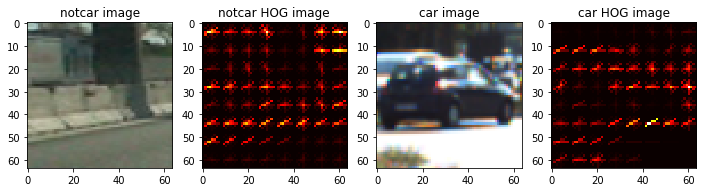

In [12]:
%matplotlib inline

# Random car / not-car indices
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))

# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

#Define features parameters
color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 6
pix_per_cell = 8
cell_per_block = 2
hog_channel = 2 # Can be 0, 1, 2, or 'ALL'
spatial_size = (16,16) # Spatial binning dimensions
hist_bins = 16
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off


car_features, car_hog_image = single_img_features(car_image, color_space=color_space, spatial_size=spatial_size, \
                                                  hist_bins=hist_bins, orient=orient, \
                                                  pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel, \
                                                  spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, vis=True)
notcar_features, notcar_hog_image = single_img_features(notcar_image, color_space=color_space, spatial_size=spatial_size,\
                                                        hist_bins=hist_bins, orient=orient, \
                                                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel, \
                                                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, vis=True)


images = [notcar_image, notcar_hog_image, car_image, car_hog_image]
titles = ['notcar image', 'notcar HOG image','car image', 'car HOG image' ]
fig = plt.figure(figsize=(12,3))
visualize(fig, 1, 4, images, titles)

## Step 4. Train Classifier

4.1 Experiment with RGB color space

In [13]:
# Define feature parameters (23:07)
color_space = 'YCrCb' # can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # can be 0, 1, 2, or 'ALL'
spatial_size = (32,32)
hist_bins = 32
spatial_feat = True
hist_feat = True
hog_feat = True

t=time.time()
n_samples = 1000
random_idxs = np.random.randint(0,len(cars), n_samples) # choose 1000 random indicies 
test_cars = np.array(cars)[random_idxs]
test_notcars = np.array(notcars)[random_idxs]

car_features = extract_features(test_cars, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell,\
                                cell_per_block=cell_per_block, hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(test_notcars, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell,\
                                   cell_per_block=cell_per_block, hog_channel=hog_channel, spatial_feat=spatial_feat,hist_feat=hist_feat, hog_feat=hog_feat)

print(time.time() - t, 'Seconds to compute features...')

X = np.vstack((car_features, notcar_features)).astype(np.float64) # stack all feature vectors
X_scaler = StandardScaler().fit(X) # fit a per-column scaler, needs float64
scaled_X = X_scaler.transform(X) # apply the scaler to X

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split data into test and training sets
rand_state = np.random.randint(0,100)
X_train, X_test, y_train, y_test = train_test_split(\
    scaled_X, y, test_size=0.1, random_state=rand_state)

print('Using: ', orient, 'orientations, ', pix_per_cell, 'pixels per cell, ', cell_per_block, 'cells_per_block,', hist_bins, 'histogram bins, and', spatial_size, 'spatial sampling')
print('Features vector length:', len(X_train[0]))

# Choose a linear SVC
svc = LinearSVC()
#Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
print(round(time.time() - t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))



/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


11.039302110671997 Seconds to compute features...
Using:  9 orientations,  8 pixels per cell,  2 cells_per_block, 32 histogram bins, and (32, 32) spatial sampling
Features vector length: 8460
8.43 Seconds to train SVC...
Test Accuracy of SVC =  0.995


## Step 5. Train on Full Data Set

In [14]:
# Define feature parameters (23:07)
color_space = 'YCrCb' # can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # can be 0, 1, 2, or 'ALL'
spatial_size = (32,32)
hist_bins = 32
spatial_feat = True
hist_feat = True
hog_feat = True

t=time.time()
n_samples = 1000
random_idxs = np.random.randint(0,len(cars), n_samples) # choose 1000 random indicies 
test_cars = np.array(cars) #np.array(cars)[random_idxs]
test_notcars = np.array(notcars) #np.array(notcars)[random_idxs]

car_features = extract_features(test_cars, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell,\
                                cell_per_block=cell_per_block, hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(test_notcars, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell,\
                                   cell_per_block=cell_per_block, hog_channel=hog_channel, spatial_feat=spatial_feat,hist_feat=hist_feat, hog_feat=hog_feat)

print(time.time() - t, 'Seconds to compute features...')

X = np.vstack((car_features, notcar_features)).astype(np.float64) # stack all feature vectors
X_scaler = StandardScaler().fit(X) # fit a per-column scaler, needs float64
scaled_X = X_scaler.transform(X) # apply the scaler to X

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split data into test and training sets
rand_state = np.random.randint(0,100)
X_train, X_test, y_train, y_test = train_test_split(\
    scaled_X, y, test_size=0.1, random_state=rand_state)

print('Using: ', orient, 'orientations, ', pix_per_cell, 'pixels per cell, ', cell_per_block, 'cells_per_block,', hist_bins, 'histogram bins, and', spatial_size, 'spatial sampling')
print('Features vector length:', len(X_train[0]))

# Choose a linear SVC
svc = LinearSVC()
#Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
print(round(time.time() - t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))



/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


92.60039901733398 Seconds to compute features...
Using:  9 orientations,  8 pixels per cell,  2 cells_per_block, 32 histogram bins, and (32, 32) spatial sampling
Features vector length: 8460
11.35 Seconds to train SVC...
Test Accuracy of SVC =  0.9921



## Step 6. Train Classifier On Example Files

In [36]:
searchpath = '/Users/home/CarND-Vehicle-Detection/test_images/*'
example_images = glob.glob(searchpath)
images = []
titles = []
y_start_stop = [400, 656] # min and max in y to search slide_window()
overlap = 0.5

for img_src in example_images:
    t1 = time.time()    
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255 # cast as float and normalize since jpg
    print(np.min(img), np.max(img))
    print('made it to windows')
    
    # define how windows will search
    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop,\
                           xy_window=(64,64), xy_overlap=(overlap, overlap))

    print('number of windows: ', len(windows))
    
    # create array of hot windows
    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space,\
                                spatial_size=spatial_size, hist_bins=hist_bins,\
                                orient=orient, pix_per_cell=pix_per_cell,\
                                cell_per_block=cell_per_block,\
                                hog_channel=hog_channel, spatial_feat=spatial_feat,\
                                hist_feat=hist_feat, hog_feat=hog_feat)
    print('length of hot_windows ', len(hot_windows))
    print('hot_windows found')
    
    # create window image to draw boxes
    window_img = draw_boxes(draw_img, hot_windows, color=(0, 0, 255), thick=6)
    images.append(window_img)
    titles.append(' ')
    print(time.time()-t1, 'seconds to process one image search', len(windows), 'windows')

fig = plt.figure(figsize=(12,18), dpi=300)
visualize(fig, 5, 2, images, titles)

0.0 1.0
made it to windows
number of windows:  273


error: /Users/jenkins/miniconda/1/x64/conda-bld/conda_1486587097465/work/opencv-3.1.0/modules/imgproc/src/color.cpp:8059: error: (-215) scn == 3 || scn == 4 in function cvtColor


In [26]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2LUV)

Set up image processing pipeline

In [32]:
searchpath = '/Users/home/CarND-Vehicle-Detection/test_images/*'
example_images = glob.glob(searchpath)

out_images = []
out_maps = []
out_titles = []
out_boxes = []

ystart = 400
ystop = 656
scale = 1

# iterate over test images
for img_src in example_images:
    img_boxes = []
    t=time.time()
    count= 0
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    #Make heatmap of zeros
    heatmap = np.zeros_like(img[:,:,0])
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    
    if scale !=1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # seperate color channels
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # Define blocks and steps
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    print(nxblocks)
    print(nyblocks)
    
    nfeat_per_block = orient * cell_per_block **2
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    
    cells_per_step = 2 # define how many cells to step
    nxsteps = np.int((nxblocks - nblocks_per_window) // cells_per_step)
    nysteps = np.int((nyblocks - nblocks_per_window) // cells_per_step)
    
    # HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            count += 1
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            # Scale features and make prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1,-1))
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                win_draw = np.int(window * scale)
                cv2.rectangle(draw_img, (xbox_left, ytop_draw + ystart), (xbox_left + wind_draw, ytop_draw))
                img_boxes.append(((xbox_left, ytop_draw + ystart), (xbox_left + win_draw, ytop_draw + win_draw + ystart)))
                heatmap[ytop_draw + ystart: ystart:ytop_draw + win_draw + ystart, xbox_left:xbox_left + win_draw] +=1
        
    print(time.time()-t, 'seconds to run, total windows = ', count)
            
    out_images.append(draw_img)
    out_titles.append(img_src[-12:])
    out_images.append(heatmap)
    out_maps.append(heatmap)
    out_boxes.append(img_boxes)

fig = plt.figure(figsize=(12,24))
visualize(fig, 8,2, out_images, out_titles)

159
31


/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


TypeError: tuple indices must be integers or slices, not tuple

Create pipeline function

In [33]:
def find_cars(img, scale):
    draw_img = np.copy(img)
    #Make heatmap of zeros
    heatmap = np.zeros_like(img[:,:,0])
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale !=1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # seperate color channels
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # Define blocks and steps
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient * cell_per_block **2
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2
    nxsteps = (nxblocks - nblocks_per_window)// cells_per_step
    nysteps = (nyblocks - nblocks_per_window)// cells_per_step
    
    # HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            count += 1
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_fet3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            
            # Get color features
            spatial_features = bin_spatial(subming, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            # Scale features and make prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1,-1))
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                win_draw = np.int(window * scale)
                cv2.rectangle(draw_img, (xbox_left, ytop_draw + ystart), (xbox_left + wind_draw, ytop_draw))
                img_boxes.append(((xbox_left, ytop_draw + ystart), (xbox_left + win_draw, ytop_draw + win_draw + ystart)))
                heatmap[ytop_draw + ystart: ystart:ytop_draw + win_draw + ystart, xbox_left:xbox_left + win_draw] +=1
                
    return draw_img, heatmap

apply threshold

In [34]:
from scipy.ndimage.measurements import label

def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_labeled_bboxes(img, labels):
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        
    return img

In [35]:
out_images =[]
out_maps = []
ystart = 400
ystop = 656
scale = 1.5

for img_src in example_images:
    img = mpimg.imread(img_src)
    out_img, heat_map = find_cars(img, scale)
    labels = label(heat_map)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    out_images.append(draw_img)
    out_images.append(heat_map)
    
fig = plt.figure(figsize = (12,24))
visualize(fig, 8,2, out_images, out_titles)

/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


UnboundLocalError: local variable 'count' referenced before assignment

In [ ]:
def process_image(img):
    out_img,heat_map = find_cars(img, scale)
    labels = label(heat_map)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

In [ ]:
# import everthing for video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

test_output = 'test.mp4'
clip = VideoFileClip('project_video.mp4')
test_clip = clip.fl_image(process_image)
test_clip.write_videofile(test_output, audio=False)

In [ ]:
HTML(.format(test_output))

In [ ]:
# Define a class to receive the characteristics of each vehicle detection

class Vehicle():
    def __init__(self):
        self.detected = False
        self.n_detections = 0
        self.n_nondetections = 0
        self.xpixels
        self.ypixels
        self.recent_xfitted = []
        self.bestx = None
        self.recent_yfitted = []
        self.besty = None
        self.recent_wfitted = []
        self.bestw = None 
        self.recent_hfitted = []
        self.besth = None

##  ********** Laneline Highligting **********

## Show distortion-corrected straight-lines images

In [ ]:
# Make a list of test images
images = glob.glob('test_images/straight_lines*.jpg')

for fname in images:
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    dst = helper.undistort(img, mtx, dist)
    fig = plt.figure(figsize=(18,8))
    plt.subplot(121),plt.imshow(img),plt.title('ORIGINAL')
    plt.subplot(122),plt.imshow(dst),plt.title('UNDISTORTED')

## 5. Warp straight-lines images

In [ ]:
fig = plt.figure(figsize=(18,8))
plt.imshow(dst)
plt.plot(550, 460, '.')
plt.plot(730, 460, '.')
plt.plot(1280, 700, '.')
plt.plot(0, 700, '.')

## Show perspective-transformed straight-lines images

In [ ]:
images = glob.glob('test_images/straight_lines*.jpg')

for index, fname in enumerate(images):
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    dst = helper.undistort(img, mtx, dist)
    dst,_ = helper.warp(dst)
    fig = plt.figure(figsize=(18,8))
    plt.subplot(121),plt.imshow(img),plt.title('ORIGINAL')
    plt.subplot(122),plt.imshow(dst),plt.title('UNDISTORTED & WARPED')
    
    dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
    result = dst
    write_name = './test_images/perspective_transformed_corrected_'+str(index)+'.jpg'
    cv2.imwrite(write_name,result)
        
print('saved perspective transformed straight lines')

## Show perspective-transformed test images

In [ ]:
# Make a list of test images
images = glob.glob('test_images/test*.jpg')
for index, fname in enumerate(images):
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    dst = helper.undistort(img, mtx, dist)
    dst,_ = helper.warp(dst)
    fig = plt.figure(figsize=(18,8))
    plt.subplot(121),plt.imshow(img),plt.title('ORIGINAL')
    plt.subplot(122),plt.imshow(dst),plt.title('UNDISTORTED & WARPED')
    
    dst = cv2.cvtColor(dst, cv2.COLOR_RGB2BGR)
    result = dst
    write_name = './test_images/perspective_transformed_warped_'+str(index)+'.jpg'
    cv2.imwrite(write_name,result)
        
print('saved perspective transformed test images')

## 6. Create thresholded binary images: based on colorspace channels

In [ ]:
images = glob.glob('test_images/test*.jpg')

for index, fname in enumerate(images):
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = helper.undistort(img, mtx, dist)
    img,_ = helper.warp(img)
    dst1,dst2,dst3 = helper.color_thred(img)
    fig = plt.figure(figsize=(18,8))
    plt.subplot(141),plt.imshow(img),plt.title('WARPED')
    plt.subplot(142),plt.imshow(dst1,'gray'),plt.title('HLS - L')
    plt.subplot(143),plt.imshow(dst2,'gray'),plt.title('LAB - B')
    plt.subplot(144),plt.imshow(dst3,'gray'),plt.title('Combined')
    
    
print('saved all perspective transformed test images')

## Create thresholded binary images: based on Sobel gradients

In [ ]:
images = glob.glob('test_images/test*.jpg')
for index, fname in enumerate(images):
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = helper.undistort(img, mtx, dist)
    img,_ = helper.warp(img)
    dst = helper.grad_thred(img)
    fig = plt.figure(figsize=(18,8))
    plt.subplot(121),plt.imshow(img),plt.title('WARPED')
    plt.subplot(122),plt.imshow(dst,'gray'),plt.title('Gradient x')
    
print('saved Sobel gradients')

## Combine thresholded binary images based on colorspaces and gradients

In [ ]:
images = glob.glob('test_images/test*.jpg')
for index, fname in enumerate(images):
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = helper.undistort(img, mtx, dist)
    img,_ = helper.warp(img)
    dst = helper.combine_threds(img)
    fig = plt.figure(figsize=(18,8))
    plt.subplot(121),plt.imshow(img),plt.title('WARPED')
    plt.subplot(122),plt.imshow(dst,'gray'),plt.title('Combined threshold')
    
print('saved all Combined Threshold test images')

## 7. Find lane lines, and fit polynomials of lines

In [ ]:
images = glob.glob('test_images/test*.jpg')
for fname in images:
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = helper.undistort(img, mtx, dist)
    img,_ = helper.warp(img)
    img = helper.combine_threds(img)
    leftx, lefty, rightx, righty = helper.locate_lanes(img)
    left_fit, right_fit = helper.fit_poly(leftx, lefty, rightx, righty)
    result, ploty, left_fitx, right_fitx = helper.fit_poly_plot(
        img, left_fit, right_fit, leftx, lefty, rightx, righty)
    fig = plt.figure(figsize=(18,8))
    plt.subplot(121),plt.imshow(img,'gray'),plt.title('WARPED')
    plt.subplot(122),plt.imshow(result),plt.title('LANE LINES FOUND')
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

## 8. Project fitted lines to orginal images

In [ ]:
images = glob.glob('test_images/test*.jpg')
for fname in images:
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img0 = helper.undistort(img, mtx, dist)
    img, Minv = helper.warp(img0)
    img = helper.combine_threds(img)
    leftx, lefty, rightx, righty = helper.locate_lanes(img)
    left_fit, right_fit = helper.fit_poly(leftx, lefty, rightx, righty)
    left_fit_m, right_fit_m = helper.fit_poly_m(leftx, lefty, rightx, righty)
    _, ploty, left_fitx, right_fitx = helper.fit_poly_plot(img, left_fit, right_fit, leftx, lefty, rightx, righty)
    result = helper.project_lines(img0, img, Minv, ploty, left_fitx, right_fitx)
    left_curverad, right_curverad = helper.get_curv_m(img, left_fit_m, right_fit_m)
    curverad = (left_curverad + right_curverad) / 2
    left2c, right2c = helper.dist2center_m(img, left_fit, right_fit)
    if left2c < right2c: str_side = 'left'
    else: str_side = 'right'
    fig = plt.figure(figsize=(18,8))
    font = {'family': 'sans-serif',
            'color':  'white',
            'weight': 'bold',
            'size': 'xx-large',
           }
    plt.subplot(121),plt.imshow(img0),plt.title('ORIGINAL')
    plt.subplot(122),plt.imshow(result),plt.title('PROJECTED LANES')
    plt.text(100, 50, 'Radius of Curvature = {:.0f}m'.format(curverad), fontdict=font)
    plt.text(100, 100, 'Vehicle is {:.2f}m {:s} of center'.
             format(np.absolute((right2c-left2c)/2.), str_side), fontdict=font)

## 9. Process videos

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import lineTracker

def process_image(img):
    return helper.process_image(img, mtx, dist, left, right)

In [ ]:
left = line.Line()
right = line.Line()
video_output = 'test.mp4'
clip1 = VideoFileClip("project_video.mp4")
video_clip = clip1.fl_image(process_image)
%time video_clip.write_videofile(video_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

## Challenge video

In [ ]:
left = line.Line()
right = line.Line()
video_output = 'test_challenge.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
video_clip = clip1.fl_image(process_image)
%time video_clip.write_videofile(video_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

## Harder challenge video

In [ ]:
left = line.Line()
right = line.Line()
video_output = 'test_harder.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")
video_clip = clip1.fl_image(process_image)
%time video_clip.write_videofile(video_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))